# Advection-Diffusion Problem: Contaminant Transport in a River
Tomasz Makowski

## Physical Scenario

A one-dimensional transport of a dissolved contaminant in a river is considered. The contaminant is released from a point source (e.g., an industrial outflow) and is transported downstream by the river current (advection), while simultaneously undergoing spreading due to molecular and turbulent mixing (diffusion).

This phenomenon is modeled using the one-dimensional advection-diffusion equation:

$$
\frac{\partial C}{\partial t} + u \frac{\partial C}{\partial x} - D \frac{\partial^2 C}{\partial x^2} = 0
$$

where:
- $C(x, t)$ — concentration of the contaminant [mol/m³],

- $u$ — constant flow velocity of the river [m/s],

- $D$ — diffusion coefficient [m²/s],

- $x$ — spatial coordinate along the river [m],

- $t$ — time [s].

## Parameter Values

The following parameter values have been defined for this analysis:
- Flow velocity: $u = 1.75$ m/s

- Diffusion coefficient: $D = 0.01$ m²/s

- Length of the domain: $L = 6$ m

- Total simulation time: $T = 2.05$ s

In the subsequent steps, an analytical solution will be derived and implemented. Then, a numerical approximation will be computed using a finite difference scheme. The results will be compared using the Root Mean Square Error (RMSE), and conclusions will be drawn regarding the accuracy of the numerical solution.


## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils import show_anim

## Params grid

In [2]:
x_min = -1.0
x_max = 5.0
nx = 600
x = np.linspace(x_min, x_max, nx, endpoint=False)
dx = (x_max - x_min) / nx

M = 0.02
D = 0.01
u = 1.75

t_start = 0.05
t_end = 2.0
nt = 3000
dt = (t_end - t_start) / nt

## Analytical Solution

In [3]:
def analytical_advection_diffusion(x: np.ndarray, t: float, M: float, D: float, u: float) -> np.ndarray:
    return M / np.sqrt(4 * np.pi * D * t) * np.exp(- (x - u * t)**2 / (4 * D * t))

psi_init = analytical_advection_diffusion(x, t_start, M, D, u)

## Numerical Solution

In [4]:
eps = 1e-12

def F(psi_l, psi_r, C):
    return 0.5 * (C + np.abs(C)) * psi_l + \
           0.5 * (C - np.abs(C)) * psi_r

class shift:
    def __init__(self, add, sub) -> None:
        self.a = add
        self.s = sub

    def __radd__(self, other):
        return slice(other.start + self.a, other.stop + self.a)

    def __rsub__(self, other):
        return slice(other.start - self.s, other.stop - self.s)

one = shift(add=1, sub=1)
hlf = shift(add=0, sub=1)

In [5]:
psi_init = analytical_advection_diffusion(x, t_start, M, D, u)
psi = psi_init.copy()

i = slice(1, nx - 1)
im = slice(1, nx)

dx_val = dx
dt_val = dt
u_val = u
D_val = D

C = np.zeros(len(psi) - 1)
output = [psi.copy()]

for index in range(nt + 1):
    psi_sum = psi[im] + psi[im - one] + eps
    psi_diff = psi[im] - psi[im - one]
    numerator = u_val - 2.0 * D_val / dx_val * (psi_diff / psi_sum)
    C[im - hlf] = dt_val / dx_val * numerator

    psi[i] -= F(psi[i], psi[i + one], C[i + hlf]) - F(psi[i - one], psi[i], C[i - hlf])

    output.append(psi.copy())

## Visualization & Comparison


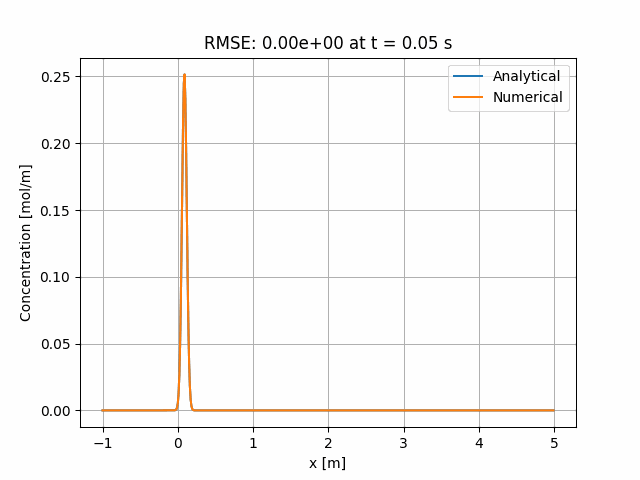

HTML(value="<a href='.\\tmpvkbjo3nv.gif' target='_blank'>.\\tmpvkbjo3nv.gif</a><br>")

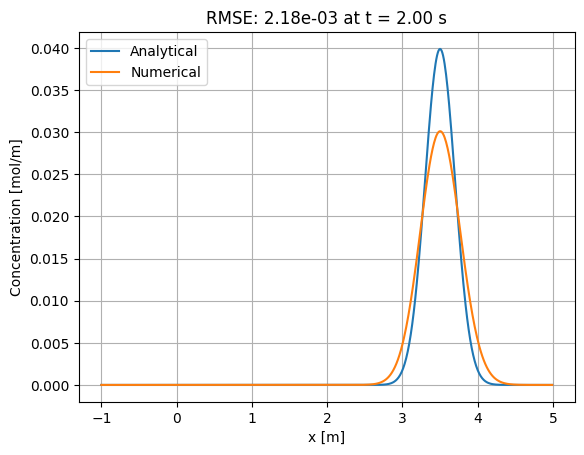

In [6]:
def RMSE(predictions: np.ndarray, targets: np.ndarray) -> float:
    return np.sqrt(np.mean((predictions - targets) ** 2))

def plot_comparison(step: int, rmse_history: dict[int, float]) -> plt.Figure:
    current_t = t_start + step * dt

    analytical = analytical_advection_diffusion(x, current_t, M, D, u)
    numerical = output[step]

    rmse_val = RMSE(analytical, numerical)
    rmse_history[step] = rmse_val

    fig = plt.figure()
    plt.plot(x, analytical, label='Analytical')
    plt.plot(x, numerical, label='Numerical')
    plt.title(f'RMSE: {rmse_val:.2e} at t = {current_t:.2f} s')
    plt.xlabel('x [m]')
    plt.ylabel('Concentration [mol/m]')
    plt.legend()
    plt.grid(True)
    return fig

rmse_history = {}
comparison_plot = plot_comparison(nt, rmse_history)

show_anim(lambda step: plot_comparison(step, rmse_history), range(0, nt, 10))

## Conclusions

At the final simulation time $t = 2.00\ \text{s}$, both the analytical and numerical solutions remain closely aligned, with a low RMSE of $2.18 \times 10^{-3}$. The overall shape and position of the contaminant plume are accurately captured by the numerical method. However, the numerical profile exhibits slightly more diffusion, resulting in a smoother and lower peak compared to the analytical solution.
